In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sigma = 9
params = 'OW0.5_Npix-600-15000' # 'OW0.5_Npix-1296-32400'
datestart, dateend = "2012-04-10", "2012-05-04"
experiment_name = "INALT60.L120-KRS0020"  
data_resolution = "1d" 

In [ ]:
ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/Parcels-mask_depths--3_{datestart.replace("-", "")}_{dateend.replace("-", "")}_{params}.nc')

In [5]:
data_path = f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{experiment_name}/nemo/'
mesh_mask = xr.open_dataset(data_path + 'suppl/2_INALT60.L120-KRS0020_mesh_mask.nc')
u_ds = xr.open_mfdataset(data_path + f'output/2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_U.nc', chunks={'time_counter': 50})
v_ds = xr.open_mfdataset(data_path + f'output/2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_V.nc', chunks={'time_counter': 50})
t_ds = xr.open_mfdataset(data_path + f'output/2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_T.nc', chunks={'time_counter': 50})

In [6]:
# smoothed
u_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_U.nc',
    chunks={'time_counter': 50}
)
v_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_V.nc',
    chunks={'time_counter': 50}
)
t_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_T.nc',
    chunks={'time_counter': 50}
)

In [12]:
u = u_ds.isel(depthu=0, time_counter = 0).vozocrtx
v = v_ds.isel(depthv=0, time_counter = 0).vomecrty
ssh = t_ds.isel(deptht=0, time_counter = 0).sossheig

u_depth = u.rename({'depthu': 'depth'})
v_depth = v.rename({'depthv': 'depth'})

dudy = (u_depth - u_depth.shift(y=1)) / mesh_mask.e2t # meridional derivative on F-grid
dvdx = (v_depth - v_depth.shift(x=1)) / mesh_mask.e1t # zonal derivative on F-grid
f = mesh_mask.ff # (from mesh_mask.nc) # alternatively: 2 * 7.2921e-5 * xr.ufuncs.sin(2 * 3.14159265359 * gphif / 360) # planetary vorticity on the F-grid
vort = (dvdx - dudy) / f # normalized relative vorticity on F-grid

In [13]:
# smoothed
u_smoothed = u_ds_smoothed.isel(depthu=0, time_counter = 0).vozocrtx
v_smoothed = v_ds_smoothed.isel(depthv=0, time_counter = 0).vomecrty
ssh_smoothed = t_ds_smoothed.isel(deptht=0, time_counter = 0).sossheig

u_smoothed_depth = u_smoothed.rename({'depthu': 'depth'})
v_smoothed_depth = v_smoothed.rename({'depthv': 'depth'})

dudy_smoothed = (u_smoothed_depth - u_smoothed_depth.shift(y=1)) / mesh_mask.e2t # meridional derivative on F-grid
dvdx_smoothed = (v_smoothed_depth - v_smoothed_depth.shift(x=1)) / mesh_mask.e1t # zonal derivative on F-grid
vort_smoothed = (dvdx_smoothed - dudy_smoothed) / f # normalized relative vorticity on F-grid

In [19]:
def plot_background(ax, mesh_mask, ds):
    ax.contourf(
        mesh_mask.nav_lon, mesh_mask.nav_lat, 
        mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), 
        colors='black'
    )
    ax.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, ds.isel(time_counter=0, z=0).type, levels=[-0.9, 0.9], colors='black')

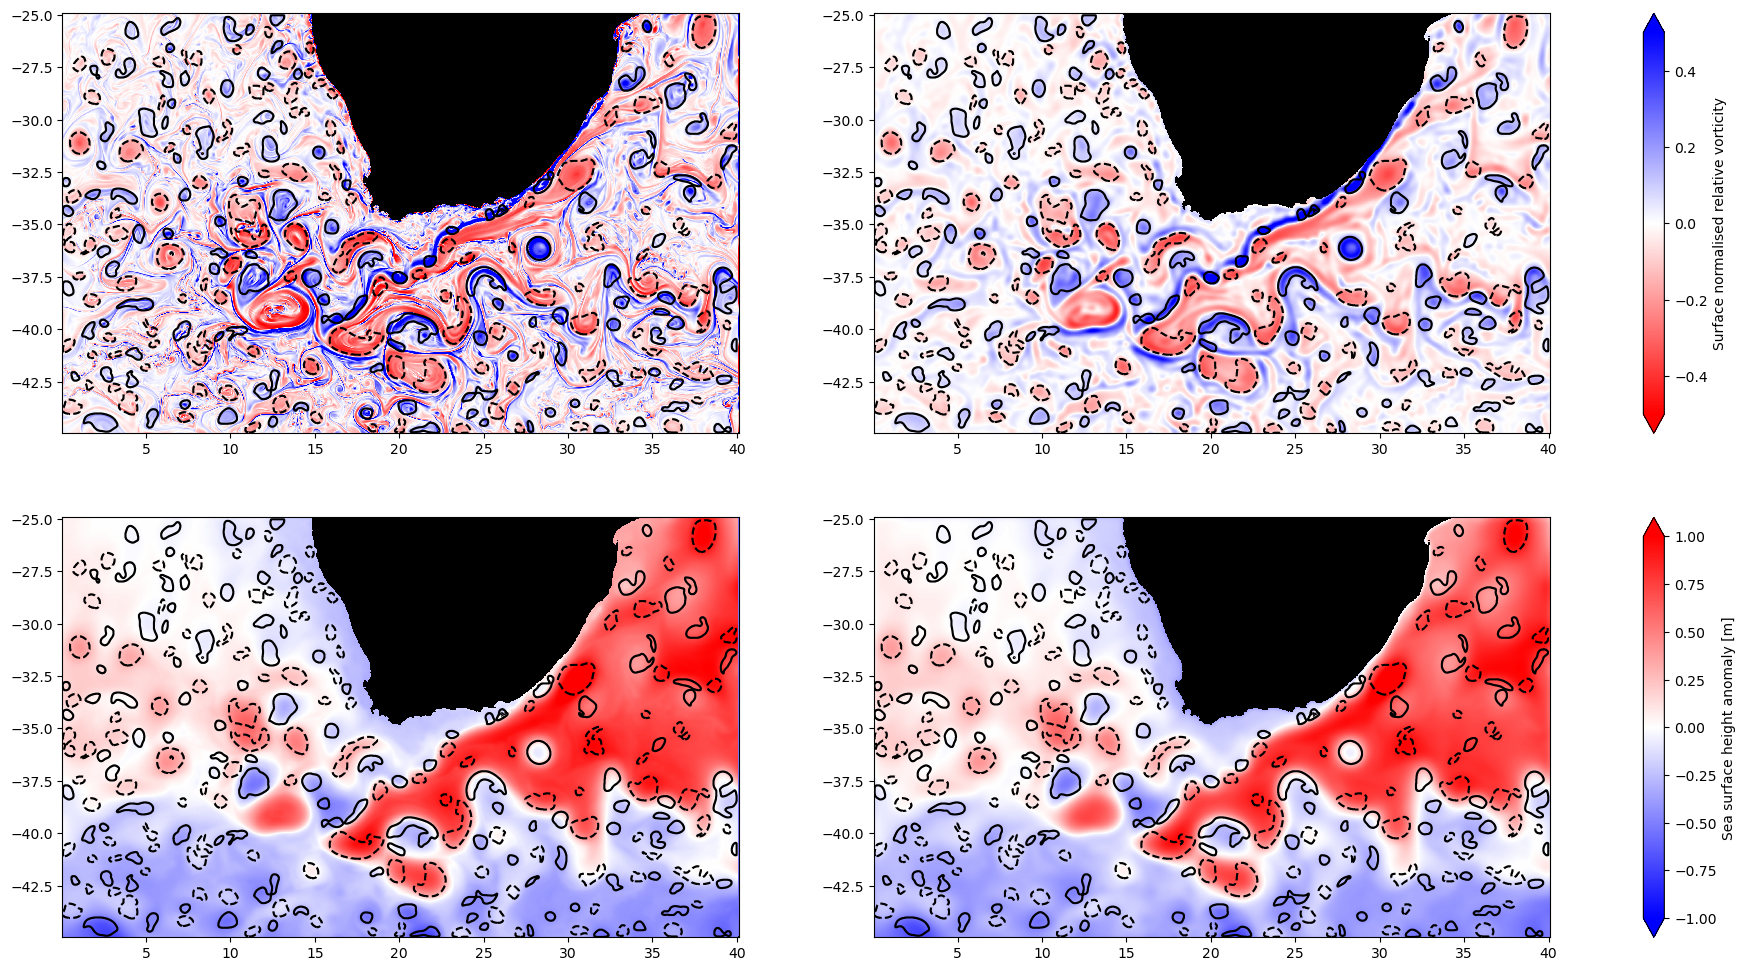

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12)) 

vmin_vort, vmax_vort = -0.5, 0.5
vmin_ssh, vmax_ssh = -1, 1

cm1 = axes[0, 0].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vort.isel(t=0), vmin=vmin_vort, vmax=vmax_vort, cmap='bwr_r')
plot_background(axes[0, 0], mesh_mask, ds)
cm2 = axes[0, 1].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, vort_smoothed.isel(t=0), vmin=vmin_vort, vmax=vmax_vort, cmap='bwr_r')
plot_background(axes[0, 1], mesh_mask, ds)

cm3 = axes[1, 0].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, ssh-ssh.mean(), vmin=vmin_ssh, vmax=vmax_ssh, cmap='bwr')
plot_background(axes[1, 0], mesh_mask, ds)
cm4 = axes[1, 1].pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, ssh_smoothed-ssh_smoothed.mean(), vmin=vmin_ssh, vmax=vmax_ssh, cmap='bwr')
plot_background(axes[1, 1], mesh_mask, ds)

cbar1 = fig.colorbar(cm1, ax=axes[0, :], orientation='vertical', extend='both')
cbar1.set_label("Surface normalised relative vorticity")
cbar2 = fig.colorbar(cm3, ax=axes[1, :], orientation='vertical', extend='both')
cbar2.set_label("Sea surface height anomaly [m]")